In [2]:
import os
import pandas as pd
import json
from collections import defaultdict

def filter_only_mixed(moi_dict):

    filtered_dict = defaultdict(dict)

    for sample, allele_dict in moi_dict.items():
        if len(allele_dict) > 1:
            filtered_dict[sample] = allele_dict
    
    return filtered_dict


def parse_data(jdata, meta_df):  

    host_dict =  {row['name'] : row['Host'] for index, row in meta_df.iterrows()}
    geo_dict = {row['name'] : row['continent'] for index, row in meta_df.iterrows()}

    host_jdata = defaultdict(dict)
    geo_jdata = defaultdict(dict)
    cooc_data = {}
    for sid, alleles in jdata.items():
        cooc_data[sid] = alleles
        host_jdata[host_dict[sid]][sid] = alleles
        geo_jdata[geo_dict[sid]][sid] = alleles

    moi_dict = filter_only_mixed(cooc_data)

    host_moi_jdata = defaultdict(dict)
    for sid, alleles in moi_dict.items():
        host_moi_jdata[host_dict[sid]][sid] = alleles
        
    return moi_dict, host_dict, geo_dict


def gen_cont_by_poly_dict(moi_dict, host_dict, geo_dict):
    cont_by_host_by_poly_dict = defaultdict(lambda: defaultdict(int))
    for d, cont in geo_dict.items():
        if cont not in ["North America", "Europe"]:
            continue
        
        host = host_dict[d]
        
        ## host filter
        if host not in ["Homo sapiens", "Bos taurus"]:
            continue
        
        if d in moi_dict:
            cont_by_host_by_poly_dict[cont][f"{host}_poly"]+=1
        else:
            cont_by_host_by_poly_dict[cont][f"{host}_mono"]+=1

    pd.DataFrame(cont_by_host_by_poly_dict)
    
    return cont_by_host_by_poly_dict


meta_csv = "../c_parvum_BM_dataset_metadata.csv"
meta_df = pd.read_csv(meta_csv)

with open("../data/filtered_gp60_MOI_0.15_0.075_AF0.05_cov3.json", 'r') as fin:
    jdata = json.load(fin)
    
moi_dict, host_dict, geo_dict = parse_data(jdata, meta_df)
cont_by_host_by_poly_dict = gen_cont_by_poly_dict(moi_dict, host_dict, geo_dict)


In [3]:
data_dict = defaultdict(lambda: defaultdict(list))
moi_count = 0

for sid, alleles in jdata.items():
    host = host_dict[sid]
    geo = geo_dict[sid]
    
    if host not in data_dict[geo]:
        data_dict[geo][host] = [0, 0]
    
    if len(alleles) == 1:
        data_dict[geo][host][0]+=1
    else:
        data_dict[geo][host][1]+=1
        moi_count+=1

df = pd.DataFrame(data_dict)
df.T

,Mus musculus,Homo sapiens,Bos taurus,Ovis aries,Capra hircus,Addax,Camelus bactrianus
North America,"[2, 0]","[163, 13]","[44, 8]",NaN,NaN,NaN,NaN
Europe,NaN,"[62, 3]","[77, 11]","[12, 1]","[7, 0]",NaN,NaN
Asia,"[3, 0]",NaN,"[148, 12]",NaN,NaN,"[1, 0]","[1, 0]"
Africa,NaN,"[7, 0]","[17, 0]",NaN,NaN,NaN,NaN


In [8]:
import numpy as np
from statsmodels.stats.contingency_tables import StratifiedTable, Table2x2


def runCMH(counts):

    HOST_A, HOST_B = "Bos taurus", "Homo sapiens"

    tables = []
    labels = []
    for cont, d in counts.items():
        try:
            a_poly = d[f"{HOST_A}_poly"]; a_mono = d[f"{HOST_A}_mono"]
            b_poly = d[f"{HOST_B}_poly"]; b_mono = d[f"{HOST_B}_mono"]
        except KeyError:
            continue
        T = np.array([[a_poly, a_mono],
                    [b_poly, b_mono]], dtype=float)
        tables.append(T); labels.append(cont)

    if not tables:
        raise ValueError("No continents with both hosts present.")

    ## per-continent ORs (Woolf CIs)
    print("Per-continent odds ratios (cattle vs human):")
    for cont, T in zip(labels, tables):
        tt = Table2x2(T)
        or_hat = tt.oddsratio
        ci_lo, ci_hi = tt.oddsratio_confint()    ## CIs
        
        pr_a = T[0,0] / (T[0,0]+T[0,1])
        pr_b = T[1,0] / (T[1,0]+T[1,1])
        print(f"  {cont:>13}: OR = {or_hat:5.2f}  (95% CI {ci_lo:5.2f}, {ci_hi:5.2f}); "
            f"poly rate cattle={pr_a:.3f}, human={pr_b:.3f}")

    ## CMH pooled OR + p
    st = StratifiedTable(tables)
    mh_or = float(st.oddsratio_pooled)
    mh_ci = tuple(st.oddsratio_pooled_confint())
    cmh_p = float(st.test_null_odds(1).pvalue)

    # Breslow–Day (homogeneity of stratum ORs)
    bd = st.test_equal_odds()
    bd_p = float(bd.pvalue)

    print("\nMantel-Haenszel pooled (Europe + North America):")
    print(f"  MH OR = {mh_or:.2f}  (95% CI {mh_ci[0]:.2f}, {mh_ci[1]:.2f})")
    print(f"  CMH p-value (H0: OR=1) = {cmh_p:.4f}")
    print(f"  Breslow-Day heterogeneity p = {bd_p:.3f}")
    
    return mh_or, cmh_p
    

runCMH(cont_by_host_by_poly_dict)

Per-continent odds ratios (cattle vs human):
         Europe: OR =  5.50  (95% CI  1.81, 16.75); poly rate cattle=0.232, human=0.052
  North America: OR =  0.69  (95% CI  0.14,  3.29); poly rate cattle=0.035, human=0.050

Mantel-Haenszel pooled (Europe + North America):
  MH OR = 2.85  (95% CI 1.30, 6.22)
  CMH p-value (H0: OR=1) = 0.0171
  Breslow-Day heterogeneity p = 0.025


(2.8471855076970924, 0.017073466588828135)

In [7]:
or_hm = defaultdict(dict)
p_hm = defaultdict(dict)

rdir = "../data/stutter_filter_c_vs_af/"
for f in os.listdir(rdir):
    if f.endswith("_polyclonal.json") or f.endswith(".csv"):
        continue
    
    af = float(f.split("MOI_")[1].split("_")[0])
    cov = int(f.split("cov")[1].split(".")[0])

    print(rdir + f, af, cov)
    with open(rdir + f, 'r') as fin:
        jdata = json.load(fin)
    
    moi_dict, host_dict, geo_dict = parse_data(jdata, meta_df)
    cont_by_host_by_poly_dict = gen_cont_by_poly_dict(moi_dict, host_dict, geo_dict)
    cmh_or, cmh_p = runCMH(cont_by_host_by_poly_dict)
    
    or_hm[af][cov] = cmh_or
    p_hm[af][cov] = cmh_p

../data/stutter_filter_c_vs_af/filtered_gp60_MOI_0.03_0.015_AF0.05_cov15.json 0.03 15
Per-continent odds ratios (cattle vs human):
         Europe: OR =  7.25  (95% CI  2.41, 21.79); poly rate cattle=0.284, human=0.052
  North America: OR =  0.72  (95% CI  0.23,  2.25); poly rate cattle=0.070, human=0.094

Mantel–Haenszel pooled (Europe + North America):
  MH OR = 2.64  (95% CI 1.37, 5.09)
  CMH p-value (H0: OR=1) = 0.0079
  Breslow–Day heterogeneity p = 0.003
../data/stutter_filter_c_vs_af/filtered_gp60_MOI_0.29_0.145_AF0.05_cov29.json 0.29 29
Per-continent odds ratios (cattle vs human):
         Europe: OR =  8.56  (95% CI  0.46, 159.10); poly rate cattle=0.053, human=0.006
  North America: OR =  0.79  (95% CI  0.09,  7.18); poly rate cattle=0.018, human=0.022

Mantel–Haenszel pooled (Europe + North America):
  MH OR = 2.47  (95% CI 0.60, 10.21)
  CMH p-value (H0: OR=1) = 0.3949
  Breslow–Day heterogeneity p = 0.165
../data/stutter_filter_c_vs_af/filtered_gp60_MOI_0.12_0.06_AF0.05_co

In [17]:
cmh_or, cmh_p = runCMH(cont_by_host_by_poly_dict)

Per-continent odds ratios (cattle vs human):
         Europe: OR =  5.50  (95% CI  1.81, 16.75); poly rate cattle=0.232, human=0.052
  North America: OR =  0.69  (95% CI  0.14,  3.29); poly rate cattle=0.035, human=0.050

Mantel-Haenszel pooled (Europe + North America):
  MH OR = 2.85  (95% CI 1.30, 6.22)
  CMH p-value (H0: OR=1) = 0.0171
  Breslow-Day heterogeneity p = 0.025


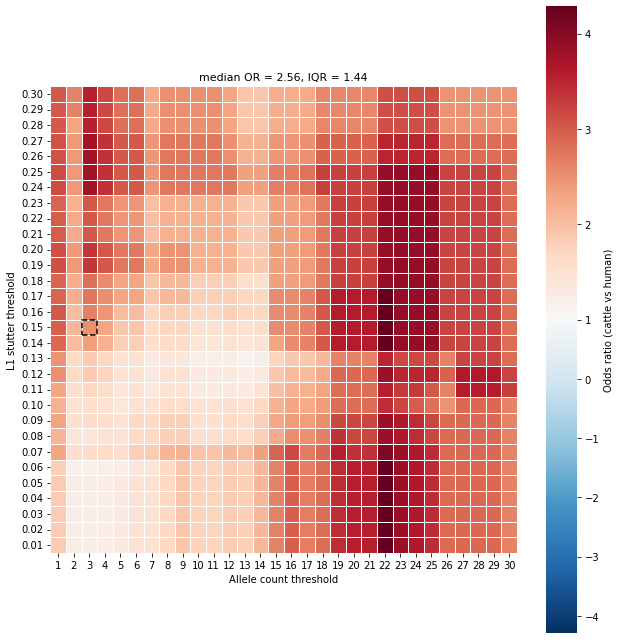

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import TwoSlopeNorm


def grid_to_frame(nested):
    rows = sorted(nested.keys())
    cols = sorted({k for d in nested.values() for k in d.keys()})
    M = pd.DataFrame(index=rows, columns=cols, dtype=float)
    for r, sub in nested.items():
        for c, v in sub.items():
            M.loc[r, c] = v
    return M.sort_index(), rows, cols


def plot_or_grid(or_grid, pval_grid=None, alpha=0.05,
                 l1_band=(0.05, 0.20), min_count_mask=None,
                 log2=True, cmap="RdBu_r"):
    """
    or_grid: nested dict {L1: {allele_count: OR}}
    pval_grid: nested dict {L1: {allele_count: p}} (optional)
    min_count_mask: DataFrame same shape with booleans (True=keep, False=mask), optional
    """
    vcenter = 0 if log2 else 1
    
    OR, rows, cols = grid_to_frame(or_grid)
    Z = np.log2(OR) if log2 else OR

    ## mask missing / low-count cells
    mask = OR.isna().values
    if min_count_mask is not None:
        mask |= ~min_count_mask.reindex(index=OR.index, columns=OR.columns).fillna(False).values

    ## colour limits for plot
    if log2:
        vmax = np.nanpercentile(np.abs(Z.values), 95)
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
        cbar_label = "log₂(OR)  (cattle vs human)"
        fmt = ".2f"
    else:
        vmax = np.nanpercentile(np.abs(Z.values - 1), 95) + 1
        m = max(OR.max().max(), vmax)
        norm = TwoSlopeNorm(vmin=-m, vcenter=1.0, vmax=m)
        cbar_label = "Odds ratio (cattle vs human)"
        fmt = ".2f"
    
    fig, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(Z, cmap=cmap, mask=mask, norm=norm, square=True,
                linewidths=0.6, linecolor="white", cbar_kws={"label": cbar_label}, ax=ax)

    ax.invert_yaxis()
    ax.set_xlabel("Allele count threshold")
    ax.set_ylabel("L1 stutter threshold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels([f"{r:.2f}" for r in OR.index], rotation=0)

    ## significance overal
    # if pval_grid is not None:
    #     P, *_ = grid_to_frame(pval_grid)
    #     P = P.reindex_like(OR)
    #     sig = (P < alpha) & ~OR.isna()
    #     y_idx, x_idx = np.where(sig.values & ~mask)
    #     ax.scatter(x_idx + 0.5, y_idx + 0.5, s=12, c="k", marker="o", linewidths=0)

    # highlight the “reasonable band” used for your primary analysis
    if l1_band is not None:
        l1, cov = l1_band
        try:
            ylo = np.argmin(np.abs(OR.index.values - lo))
            yhi = np.argmin(np.abs(OR.index.values - hi))
            y0, y1 = sorted([ylo, yhi])
            ax.add_patch(plt.Rectangle((0, y0), width=len(cols), height=(y1 - y0),
                                       fill=False, edgecolor="k", linewidth=1.5, linestyle="--"))
        except Exception:
            pass
        
    ax.add_patch(plt.Rectangle((2, 14), width=1, height=1,
                                       fill=False, edgecolor="k", linewidth=1.5, linestyle="--"))

    # quick robustness summary
    band = OR.loc[(OR.index >= l1_band[0]) & (OR.index <= l1_band[1])]
    bandZ = (np.log2(band) if log2 else band).values
    med = np.nanmedian(bandZ)
    iqr = np.nanpercentile(bandZ, 75) - np.nanpercentile(bandZ, 25)
    ax.set_title(f"median {('log₂(OR)' if log2 else 'OR')} = {med:{fmt}}, IQR = {iqr:{fmt}}",
                 fontsize=11)

    plt.savefig("hypothesis_parameter_sweep.png", dpi=600, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

fig, ax = plot_or_grid(or_hm, pval_grid=p_hm, alpha=0.05, l1_band=(0.05, 0.20), log2=False)



## Quick association checks
### Depth by host

In [11]:
depth_by_host = defaultdict(list)

for id, alleles in moi_dict.items():
    depth = sum([x[2] for x in alleles])
    host = host_dict[id]
    depth_by_host[host].append(depth)

for host, depths in depth_by_host.items():
    print(host, np.mean(depths), np.std(depths))

Bos taurus 319.48275862068965 182.45578031868533
Ovis aries 277.0 0.0
Homo sapiens 260.46153846153845 116.78883994669471
Capra hircus 317.0 0.0


### Depth by polyclonality

In [12]:
depth_by_poly = defaultdict(list)

for id, alleles in jdata.items():
    depth = sum([x[2] for x in alleles])
    
    if len(alleles) > 1:
        depth_by_poly["poly"].append(depth)
    else:
        depth_by_poly["mono"].append(depth)

for clonality, depths in depth_by_poly.items():
    print(clonality, np.mean(depths), np.std(depths))

mono 96.18248175182482 94.29977970406436
poly 301.02272727272725 163.4035006630079


### Major allele length by polyclonality

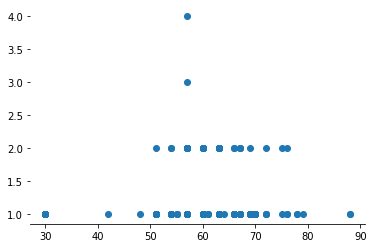

In [13]:
x = []
y = []

for id, alleles in jdata.items():
    maj_l = len(sorted(alleles, key=lambda x: x[2], reverse=True)[0][0])  
    n_alleles = len(alleles)
    
    x.append(maj_l)
    y.append(n_alleles)

plt.scatter(x, y)

## Test relationship between polyclonality and other categories

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, pointbiserialr, chi2
import statsmodels.formula.api as smf

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    n, m = len(x), len(y)
    wins = sum((xi > y).sum() for xi in x)
    losses = sum((xi < y).sum() for xi in x)
    return (wins - losses) / (n * m)

def depth_length_sanity(df):
    def _clean_numeric(s):
        s = pd.to_numeric(pd.Series(s), errors='coerce').astype(float)
        s = s.replace([np.inf, -np.inf], np.nan).dropna()
        return s.to_numpy(dtype=float)

    df = df.copy()

    df["poly"] = df["poly"].astype(int)

    df["depth"] = pd.to_numeric(df["depth"], errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan)

    mono = _clean_numeric(df.loc[df["poly"] == 0, "depth"])
    poly = _clean_numeric(df.loc[df["poly"] == 1, "depth"])
    
    mod2 = smf.logit("poly ~ depth + major_len + C(host) + C(continent) + C(family)",
                 data=df).fit(disp=0)
    
    if mono.size == 0 or poly.size == 0:
        raise ValueError(f"Empty group: mono={mono.size}, poly={poly.size}")

    u_stat, p_mwu = mannwhitneyu(poly, mono, alternative="two-sided")
    delta = cliffs_delta(poly, mono)

    r_depth, p_r_depth   = pointbiserialr(df["poly"], df["depth"])
    r_len,   p_r_len     = pointbiserialr(df["poly"], df["major_len"])

    ## human reference, so test OR against cattle
    if "Homo sapiens" in df["host"].unique() and "Bos taurus" in df["host"].unique():
        df["host"] = pd.Categorical(df["host"], categories=["Homo sapiens","Bos taurus"])
        
    ## fit logistic regression with continent controls
    mod = smf.logit("poly ~ depth + major_len + C(host) + C(continent)", data=df).fit(disp=0)

    ci = mod.conf_int()
    params = mod.params

    out = {
        "mwu_depth": {"U": float(u_stat), "p": float(p_mwu), "cliffs_delta": float(delta)},
        "point_biserial": {
            "depth": {"r": float(r_depth), "p": float(p_r_depth)},
            "major_len": {"r": float(r_len), "p": float(p_r_len)}
        },
        "logit_summary": mod.summary2().as_text(),
        "adjusted_ORs": {
            "depth": {
                "OR": float(np.exp(params["depth"])),
                "CI95": tuple(np.exp(ci.loc["depth"]).values)
            },
            "major_len": {
                "OR": float(np.exp(params["major_len"])),
                "CI95": tuple(np.exp(ci.loc["major_len"]).values)
            }
        }
    }

    ## report  adjusted OR
    for k in params.index:
        if k.startswith("C(host)[T.Bos taurus]"):
            out["adjusted_ORs"]["Bos taurus vs Homo sapiens"] = {
                "OR": float(np.exp(params[k])),
                "CI95": tuple(np.exp(ci.loc[k]).values)
            }

    ## test whether adding hostxdepth or hostxlength improves fit
    try:
        mod_int = smf.logit(
            "poly ~ depth + major_len + C(host) + C(continent) + depth:C(host) + major_len:C(host)",
            data=df
        ).fit(disp=0)
        llr = 2*(mod_int.llf - mod.llf)
        df_diff = int(mod_int.df_model - mod.df_model)
        p_llr = float(chi2.sf(llr, df_diff))
        out["interaction_LRT_p"] = p_llr
    except Exception:
        out["interaction_LRT_p"] = None

    return out


poly_and_mono = defaultdict(dict)

for id, alleles in jdata.items():
    maj_l = maj_l = len(sorted(alleles, key=lambda x: x[2], reverse=True)[0][0])
    family = sorted(alleles, key=lambda x: x[2], reverse=True)[0][1][-3:]
    host = host_dict[id]
    geo = geo_dict[id]
    
    if geo not in ["North America", "Europe"] or host not in ["Homo sapiens", "Bos taurus"] or family == "IIc":
        continue
    
    depth = sum([x[2] for x in alleles])
    
    poly_and_mono[id]["poly"] = int(len(alleles)>1)
    poly_and_mono[id]["depth"] = int(depth)
    poly_and_mono[id]["major_len"] = int(maj_l)
    poly_and_mono[id]["host"] = host
    poly_and_mono[id]["continent"] = geo
    poly_and_mono[id]["family"] = family
        
df = pd.DataFrame(poly_and_mono).T

results = depth_length_sanity(df)
print(results["mwu_depth"])
print(results["point_biserial"])
print(results["adjusted_ORs"])
print(results["logit_summary"])

{'U': 10647.0, 'p': 5.27111055558365e-13, 'cliffs_delta': 0.7230943518368668}
{'depth': {'r': 0.4234206726552853, 'p': 1.427719935449449e-17}, 'major_len': {'r': 0.043345548785294286, 'p': 0.4051447233495266}}
{'depth': {'OR': 1.0109959862880327, 'CI95': (np.float64(1.0072976144733303), np.float64(1.014707936963524))}, 'major_len': {'OR': 1.0953288797604412, 'CI95': (np.float64(1.0214349041491402), np.float64(1.1745685897004432))}, 'Bos taurus vs Homo sapiens': {'OR': 2.8777107236199915, 'CI95': (np.float64(1.0857151983346225), np.float64(7.627432149370341))}}
                                Results: Logit
Model:                    Logit                Method:               MLE       
Dependent Variable:       poly                 Pseudo R-squared:     0.294     
Date:                     2025-08-27 21:19     AIC:                  179.9808  
No. Observations:         371                  BIC:                  199.5618  
Df Model:                 4                    Log-Likelihood:    

/tmp/ipykernel_39566/1842114044.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace([np.inf, -np.inf], np.nan)


## Check gp60 family isnt driving major allele length association

In [15]:
iqr = df['major_len'].quantile(0.75) - df['major_len'].quantile(0.25)
OR_IQR = np.exp(0.1477 * iqr)
print(OR_IQR)

def _clean_numeric(s):
        s = pd.to_numeric(pd.Series(s), errors='coerce').astype(float)
        s = s.replace([np.inf, -np.inf], np.nan).dropna()
        return s.to_numpy(dtype=float)

df = df.copy()

df["poly"] = df["poly"].astype(int)

df["depth"] = pd.to_numeric(df["depth"], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan)

mono = _clean_numeric(df.loc[df["poly"] == 0, "depth"])
poly = _clean_numeric(df.loc[df["poly"] == 1, "depth"])

mod2 = smf.logit("poly ~ depth + major_len + C(host) + C(continent) + C(family)",
                data=df).fit(disp=0)

print(mod2.summary())

2.4258937180021234
                           Logit Regression Results                           
Dep. Variable:                   poly   No. Observations:                  371
Model:                          Logit   Df Residuals:                      365
Method:                           MLE   Df Model:                            5
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.2941
Time:                        21:19:42   Log-Likelihood:                -84.979
converged:                       True   LL-Null:                       -120.39
Covariance Type:            nonrobust   LLR p-value:                 6.935e-14
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -9.2030      2.664     -3.454      0.001     -14.425      -3.981
C(host)[T.Homo sapiens]          -1.0522      0.499    

/tmp/ipykernel_39566/750526541.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace([np.inf, -np.inf], np.nan)


## Check relationship between host and allele length


Descriptives by continent x host:
    continent         host   n      mean       sd  median  IQR
       Europe   Bos taurus  88 59.965909 5.696236    57.0  6.0
       Europe Homo sapiens  59 60.932203 6.887931    57.0  9.0
North America   Bos taurus  52 60.884615 4.638517    63.0  6.0
North America Homo sapiens 172 61.093023 5.102752    57.0  6.0

Per-continent Mann-Whitney U and Cliff's delta (Bos taurus vs Homo sapiens):
       Europe: U=2468, p=0.5981, Cliff's δ=-0.049 (n_cattle=88, n_human=59)
North America: U=4447, p=0.9483, Cliff's δ=-0.006 (n_cattle=52, n_human=172)

OLS with HC3-robust SEs (major_len ~ host + continent + host:continent):
                            OLS Regression Results                            
Dep. Variable:              major_len   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8225
Date:                Wed, 27 

/home/arthur/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


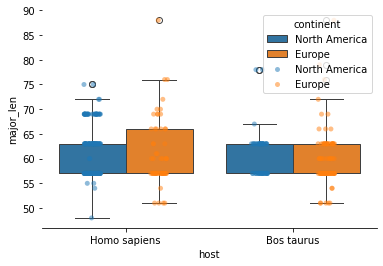

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf

## ---------- config ----------
USE_POLY_ONLY = False
HOSTS = ["Bos taurus", "Homo sapiens"]
CONTINENTS = ["Europe", "North America"]


## ---------- helpers ----------
def _clean_num(s):
    a = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    return a.to_numpy(dtype=float)

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    return (np.sum(x[:,None] > y) - np.sum(x[:,None] < y)) / (x.size * y.size)

def iqr(a): 
    return np.subtract(*np.percentile(a, [75, 25]))



## ---------- subset & clean ----------
df_ = df.copy()
if USE_POLY_ONLY:
    df_ = df_.loc[df_["poly"] == 1]

df_ = df_.loc[df_["continent"].isin(CONTINENTS) & df_["host"].isin(HOSTS)].copy()
df_["major_len"] = pd.to_numeric(df_["major_len"], errors="coerce")
df_ = df_.replace([np.inf, -np.inf], np.nan).dropna(subset=["major_len","host","continent"])



## ---------- descriptives ----------
desc = (df_
        .groupby(["continent","host"])["major_len"]
        .agg(n="size", mean="mean", sd="std", median="median", IQR=iqr)
        .reset_index())
print("\nDescriptives by continent x host:")
print(desc.to_string(index=False))



## ---------- per-continent tests ----------
print("\nPer-continent Mann-Whitney U and Cliff's delta (Bos taurus vs Homo sapiens):")
for cont in CONTINENTS:
    d = df_.loc[df_["continent"]==cont]
    a = _clean_num(d.loc[d["host"]=="Bos taurus","major_len"])
    h = _clean_num(d.loc[d["host"]=="Homo sapiens","major_len"])
    if len(a)==0 or len(h)==0:
        print(f"{cont}: insufficient data")
        continue
    u, p = mannwhitneyu(a, h, alternative="two-sided")
    delta = cliffs_delta(a, h)
    print(f"{cont:>13}: U={u:.0f}, p={p:.4g}, Cliff's δ={delta:.3f} "
          f"(n_cattle={len(a)}, n_human={len(h)})")



## ---------- adjusted linear model (robust SE) ----------
## major_len ~ host + continent + host:continent
formula = "major_len ~ C(host) + C(continent) + C(host):C(continent)"
ols = smf.ols(formula, data=df_).fit(cov_type="HC3")
print("\nOLS with HC3-robust SEs (major_len ~ host + continent + host:continent):")
print(ols.summary())

## test if interaction terms jointly = 0 (host effect same across continents)
## with Europe as baseline and NA as the test
try:
    print("\nWald test for no host x continent interaction:")
    print(ols.wald_test("C(host)[T.Homo sapiens]:C(continent)[T.North America] = 0"))
except Exception as e:
    print("\nWald test not available (likely due to coding levels):", e)

import seaborn as sns, matplotlib.pyplot as plt
sns.boxplot(data=df_, x="host", y="major_len", hue="continent")
sns.stripplot(data=df_, x="host", y="major_len", hue="continent", dodge=True, alpha=0.5)
plt.show()
